In [6]:
import os
import glob
import shutil
import random
from pathlib import Path
from dotenv import load_dotenv

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

from huggingface_hub import login as hf_login


load_dotenv()


ROOT_DIR = Path("../").resolve()
DATA_DIR = ROOT_DIR / "data" / "human_nonhuman"

In [8]:
from huggingface_hub import HfApi, login
import os

# Login using token from .env or manual input
hf_login(token=os.getenv("HF_TOKEN")) # You already have this import as hf_login

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [3]:
def get_random_index(n: int) -> int:
    return random.randint(0, n - 1)

In [6]:
# human dataset
hm_datapath = DATA_DIR / "real"
len(os.listdir(hm_datapath))

25357

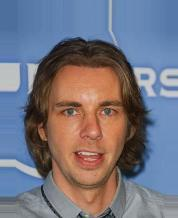

In [17]:
sample = os.listdir(hm_datapath)[get_random_index(len(os.listdir(hm_datapath)))]
sample_dir = hm_datapath / sample
sample_img = Image.open(sample_dir)
sample_img

In [45]:
# art dataset
art_datapath = DATA_DIR / "art"
len(os.listdir(art_datapath))

6360

In [44]:
# chibi dataset
chibi_datapath = DATA_DIR / "chibi"
len(os.listdir(chibi_datapath))

2692

In [43]:
# anime dataset
anime_datapath = DATA_DIR / "anime"
len(os.listdir(anime_datapath))

63565

In [42]:
# raw dataset
raw_datapath = DATA_DIR / "raw"
len(os.listdir(raw_datapath))

7

In [41]:
# statue dataset
statue_datapath = DATA_DIR / "statue"
len(os.listdir(statue_datapath))

67

In [27]:
# gaming dataset
gaming_datapath = DATA_DIR / "gaming" / "**/**.*g"
len(os.listdir(gaming_datapath))

FileNotFoundError: [Errno 2] No such file or directory: '/home/octoopt/workspace/projects/learn-from-basics/compvision_learning/data/human_nonhuman/gaming/**/**.*g'

In [28]:
import shutil
from pathlib import Path


def consolidate_dataset(src_root, dest_root):
    """
    Copies images from nested subdirectories (A/B/train, A/B/test, etc.)
    into a single directory C without losing data due to name collisions.
    """
    src_path = Path(src_root)
    dest_path = Path(dest_root)

    # Create target directory if it doesn't exist
    dest_path.mkdir(parents=True, exist_ok=True)

    count = 0
    # Iterates through all files recursively
    for file_path in src_path.rglob("*"):
        # Filter for typical image extensions (adjust if needed)
        if file_path.suffix.lower() in [".jpg", ".jpeg", ".png", ".bmp", ".webp"]:
            # Create a unique filename by joining the subfolder parts
            # Example: 'train/face_01.jpg' -> 'train_face_01.jpg'
            relative_parts = file_path.relative_to(src_path).parts
            unique_name = "_".join(relative_parts)

            target_file = dest_path / unique_name

            # Use copy2 to preserve metadata (timestamps, etc.)
            shutil.copy2(file_path, target_file)
            count += 1

    print(f"Done! Copied {count} images to: {dest_root}")


# --- Example Usage ---
# dir_A = DATA_DIR / "gaming"
# dir_C = DATA_DIR / "gaming_merged"
# consolidate_dataset(dir_A, dir_C)

In [40]:
src_dir = "/home/octoopt/Downloads/image_face"
dest_dir = DATA_DIR / "art"
consolidate_dataset(src_dir, dest_dir)

Done! Copied 6200 images to: /home/octoopt/workspace/projects/learn-from-basics/compvision_learning/data/human_nonhuman/art


In [79]:
from pathlib import Path


def rename_images(target_dir, prefix, padding=5, start_index=1, dry_run=True):
    """
    Renames all image files in a directory to a format like 'chibi_00001.png'.

    Args:
        target_dir (str or Path): Path to the folder containing images.
        prefix (str): String to put at the start (e.g., 'img', 'chibi').
        padding (int): How many digits for the number (default 5).
        start_index (int): What number to start counting from.
        dry_run (bool): If True, only prints what will happen without renaming.
    """
    path = Path(target_dir)
    if not path.exists():
        print(f"Error: {target_dir} does not exist.")
        return

    # Filter for common image extensions
    extensions = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
    image_files = sorted([f for f in path.iterdir() if f.suffix.lower() in extensions])

    if not image_files:
        print("No image files found.")
        return

    print(
        f"{'DRY RUN' if dry_run else 'EXECUTING'}: Renaming {len(image_files)} files..."
    )

    for i, file_path in enumerate(image_files, start=start_index):
        # Construct new name: prefix_00001.ext
        new_name = f"{prefix}_{i:0{padding}d}{file_path.suffix.lower()}"
        new_path = file_path.parent / new_name

        if dry_run:
            print(f"[Would Rename] {file_path.name} -> {new_name}")
        else:
            file_path.rename(new_path)

    if not dry_run:
        print("Renaming complete.")


# --- Example Usage ---
# ren_dir = DATA_DIR / "nonhuman" / "chibi"
# rename_images_sequentially(ren_dir, prefix="chibi", padding=5, dry_run=True)

In [71]:
import hashlib
from pathlib import Path


def remove_duplicate_images(target_dir, chunk_size=8192, dry_run=True):
    """
    Finds and deletes duplicate images in a directory using MD5 checksums.

    Args:
        target_dir (str or Path): Directory to scan.
        chunk_size (int): Buffer size for reading files (default 8KB).
        dry_run (bool): If True, only lists duplicates without deleting.
    """
    path = Path(target_dir)
    if not path.exists():
        print("Directory not found.")
        return

    hashes = set()
    duplicates_found = 0
    extensions = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

    # Iterate through files
    # Use rglob('*') if you want to search subfolders too
    for file_path in path.iterdir():
        if file_path.suffix.lower() not in extensions:
            continue

        # Calculate MD5 Hash
        # We read in chunks to handle large files without using too much RAM
        md5 = hashlib.md5()
        try:
            with open(file_path, "rb") as f:
                while chunk := f.read(chunk_size):
                    md5.update(chunk)

            file_hash = md5.hexdigest()

            if file_hash in hashes:
                duplicates_found += 1
                if dry_run:
                    print(f"[Duplicate Found] Would delete: {file_path.name}")
                else:
                    print(f"[Deleting] {file_path.name}")
                    file_path.unlink()
            else:
                hashes.add(file_hash)

        except Exception as e:
            print(f"Error processing {file_path.name}: {e}")

    print(
        f"\nScan complete. Total duplicates {'found' if dry_run else 'removed'}: {duplicates_found}"
    )


# --- Example Usage ---
# data_path = DATA_DIR / "nonhuman" / "raw"
# remove_duplicate_images(data_path, dry_run=True)

In [4]:
import cv2
import numpy as np
from pathlib import Path
from insightface.app import FaceAnalysis
from tqdm.auto import tqdm  # Use .auto for best notebook compatibility

app = FaceAnalysis(
    providers=["CUDAExecutionProvider"]
)  # or ['CUDAExecutionProvider'] for GPU
app.prepare(ctx_id=0, det_size=(640, 640))


def process_and_crop_faces(src_dir, dest_dir, expand_ratio=0.2, limit=None):
    """
    Args:
        limit (int): Max number of images to process. Set to None for all.
    """
    src_path = Path(src_dir)
    dest_path = Path(dest_dir)
    dest_path.mkdir(parents=True, exist_ok=True)

    extensions = {".jpg", ".jpeg", ".png", ".webp"}
    image_files = [f for f in src_path.rglob("*") if f.suffix.lower() in extensions]

    # Apply the limit (slicing)
    if limit is not None:
        image_files = image_files[:limit]
        print(f"Limiting processing to the first {limit} images.")

    print(f"Processing {len(image_files)} images...")

    for img_file in tqdm(image_files, desc=f"Cropping from {src_path.name}"):
        img = cv2.imread(str(img_file))
        if img is None:
            continue

        faces = app.get(img)

        for i, face in enumerate(faces):
            bbox = face.bbox.astype(int)
            x1, y1, x2, y2 = bbox

            w, h = x2 - x1, y2 - y1
            ew, eh = int(w * expand_ratio), int(h * expand_ratio)

            nx1 = max(0, x1 - ew)
            ny1 = max(0, y1 - eh)
            nx2 = min(img.shape[1], x2 + ew)
            ny2 = min(img.shape[0], y2 + eh)

            face_crop = img[ny1:ny2, nx1:nx2]

            # --- UNIQUE NAMING logic for nested Folders ---
            # Get folder name(s) between src_path and file
            # Example: 'Guan Yu/statue_01.jpg' -> 'Guan Yu_statue_01_face0.jpg'
            relative_folders = "_".join(img_file.relative_to(src_path).parts[:-1])
            save_name = f"{relative_folders}_{img_file.stem}_face{i}{img_file.suffix}"

            cv2.imwrite(str(dest_path / save_name), face_crop)

    print(f"Finished! Crops saved to {dest_dir}")
    # Additional line to count actual files in destination
    print(f"Total image count in destination: {len(list(Path(dest_dir).glob('*.*')))}")

Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
find model: /home/octoopt/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider']

In [78]:
src = DATA_DIR / "raw"
dest = DATA_DIR / "processed" / "statue"
process_and_crop_faces(src, dest, expand_ratio=0.2, limit=2500)

Limiting processing to the first 2500 images.
Processing 1342 images...


Cropping from raw:   0%|          | 0/1342 [00:00<?, ?it/s]

Finished! Crops saved to /home/octoopt/workspace/projects/learn-from-basics/compvision_learning/data/human_nonhuman/processed/statue
Total image count in destination: 1307


In [86]:
len(os.listdir(DATA_DIR / "processed" / "non_human"))

4213

In [74]:
data_path = DATA_DIR / "processed" / "gaming"
remove_duplicate_images(data_path, dry_run=False)

[Deleting] image_861_face0.png
[Deleting] SSG Taliyah_face2.jpg
[Deleting] SSG Gnar_face2.jpg
[Deleting] Prestige Bewitching Miss Fortune_face0.jpg
[Deleting] DWG Leona_face0.jpg
[Deleting] Sweetheart Rakan_face1.jpg
[Deleting] Prestige PROJECT- Irelia_face0.jpg
[Deleting] Fnatic Corki_face0.jpg
[Deleting] EDG Aphelios_face3.jpg
[Deleting] SSG Jarvan IV_face1.jpg
[Deleting] TPA Shen_face2.jpg
[Deleting] SSG Jarvan IV_face2.jpg
[Deleting] TPA Orianna_face0.jpg
[Deleting] Red Card Twisted Fate_face0.jpg
[Deleting] DWG Leona_face1.jpg
[Deleting] Queen of Diamonds Syndra_face0.jpg
[Deleting] SKT T1 Ekko_face0.jpg
[Deleting] TPA Shen_face0.jpg
[Deleting] DWG Kennen_face2.jpg
[Deleting] Queen of Diamonds Syndra_face1.jpg
[Deleting] SKT T1 Zac_face0.jpg
[Deleting] EDG Viego_face1.jpg
[Deleting] EDG Aphelios_face1.jpg
[Deleting] Fnatic Jarvan IV_face0.jpg
[Deleting] Prestige K-DA KaiSa_face0.jpg
[Deleting] SSG Ezreal_face0.jpg
[Deleting] Ace of Spades Ezreal_face1.jpg
[Deleting] SKT T1 Zed_fac

In [83]:
ren_dir = DATA_DIR / "processed" / "non_human"
rename_images(ren_dir, prefix="image", padding=6, dry_run=False)

EXECUTING: Renaming 4213 files...
Renaming complete.


In [1]:
def prepare_ultralytics_dataset(class_dirs, output_root, split_ratio=(0.7, 0.2, 0.1)):
    """
    Splits images into a YOLO-compatible classification structure.

    Args:
        class_dirs (dict): Map of class name to its source directory.
                           Example: {'human': 'path/to/human', 'non_human': 'path/to/non_human'}
        output_root (str/Path): Where the new dataset will be created.
        split_ratio (tuple): (train, val, test) proportions.
    """
    output_root = Path(output_root)
    train_pct, val_pct, test_pct = split_ratio

    # Define splits
    stages = ["train", "val", "test"]

    # Initialize directory structure
    for stage in stages:
        for class_name in class_dirs.keys():
            (output_root / stage / class_name).mkdir(parents=True, exist_ok=True)

    for class_name, src_dir in class_dirs.items():
        src_path = Path(src_dir)
        # Get all valid image files
        images = [
            f
            for f in src_path.iterdir()
            if f.suffix.lower() in {".jpg", ".jpeg", ".png", ".webp"}
        ]

        # Shuffle to ensure random distribution
        random.shuffle(images)

        # Calculate split indices
        num_imgs = len(images)
        train_idx = int(num_imgs * train_pct)
        val_idx = int(num_imgs * (train_pct + val_pct))

        # Categorize files
        splits = {
            "train": images[:train_idx],
            "val": images[train_idx:val_idx],
            "test": images[val_idx:],
        }

        # Copy files to new structure
        for stage, files in splits.items():
            if not files:
                continue
            for f in tqdm(files, desc=f"Moving {class_name} -> {stage}"):
                # Use copy2 to preserve metadata, or shutil.move if you want to save disk space
                shutil.copy2(f, output_root / stage / class_name / f.name)

    print(f"\nSuccessfully created Ultralytics dataset at: {output_root.resolve()}")
    for stage in stages:
        print(
            f"  - {stage}: {sum(len(os.listdir(output_root / stage / c)) for c in class_dirs.keys())} images"
        )

In [7]:
# --- Example Usage ---
class_map = {
    "human": DATA_DIR / "processed" / "human",
    "non_human": DATA_DIR / "processed" / "non_human",
}
prepare_ultralytics_dataset(class_map, output_root=DATA_DIR / "yolo_dataset")

Moving human -> train:   0%|          | 0/3024 [00:00<?, ?it/s]

Moving human -> val:   0%|          | 0/864 [00:00<?, ?it/s]

Moving human -> test:   0%|          | 0/433 [00:00<?, ?it/s]

Moving non_human -> train:   0%|          | 0/2949 [00:00<?, ?it/s]

Moving non_human -> val:   0%|          | 0/842 [00:00<?, ?it/s]

Moving non_human -> test:   0%|          | 0/422 [00:00<?, ?it/s]


Successfully created Ultralytics dataset at: /home/octoopt/workspace/projects/learn-from-basics/compvision_learning/data/human_nonhuman/yolo_dataset
  - train: 5973 images
  - val: 1706 images
  - test: 855 images


In [13]:
import os
from pathlib import Path
from datasets import load_dataset
from huggingface_hub import HfApi

# 1. Configuration
dataset_repo_id = "8Opt/human-nonhuman-face-classification"
local_path = Path("/home/octoopt/workspace/projects/learn-from-basics/compvision_learning/data/human_nonhuman/yolo_dataset")

# 2. Count Samples for README
stats = {}
for split in ['train', 'val', 'test']:
    stats[split] = {}
    for cls in ['human', 'non_human']:
        cls_path = local_path / split / cls
        count = len(list(cls_path.glob('*'))) if cls_path.exists() else 0
        stats[split][cls] = count

total_samples = sum(sum(cls_dict.values()) for cls_dict in stats.values())

# 3. Load and Push Dataset
print("Loading images into memory...")
ds = load_dataset("imagefolder", data_dir=local_path)
# 4. Push with Sharding
# max_shard_size="200MB" tells HF to split the dataset into smaller pieces.
# This prevents one single huge upload from timing out.
print(f"Pushing to Hub (with 120s timeout and sharding)...")
ds.push_to_hub(
    dataset_repo_id, 
    max_shard_size="200MB", 
    private=False
)

# 4. Create Detailed Model Card
readme_content = f"""
---
license: mit
task_categories:
- image-classification
tags:
- human-detection
- face-classification
- computer-vision
size_categories:
- 1K<n<10K
---

# Human vs Non-Human Face Dataset

A robust dataset for binary classification between real human faces and non-human face-like objects (statues, art, gaming, anime).

## 📊 Dataset Statistics
| Split | Human | Non-Human | Total |
| :--- | :--- | :--- | :--- |
| **Train** | {stats['train']['human']:,} | {stats['train']['non_human']:,} | {sum(stats['train'].values()):,} |
| **Validation** | {stats['val']['human']:,} | {stats['val']['non_human']:,} | {sum(stats['val'].values()):,} |
| **Test** | {stats['test']['human']:,} | {stats['test']['non_human']:,} | {sum(stats['test'].values()):,} |
| **Total** | | | **{total_samples:,}** |

## 📁 Format
- Images are decodable as **PIL.Image** objects.
- Labels: `0: human`, `1: non_human`.

## 🚀 Quick Start   
```python
from datasets import load_dataset
ds = load_dataset("{dataset_repo_id}")

# Access test set
example = ds['test'][0]
img, label = example['image'], example['label']
img.show()
"""

with open("temp_README.md", "w") as f:
    f.write(readme_content)

# 5. Upload README
api = HfApi()
api.upload_file(
    path_or_fileobj="temp_README.md",
    path_in_repo="README.md",
    repo_id=dataset_repo_id,
    repo_type="dataset",
)

print(f"✅ Dataset and summary pushed to: https://huggingface.co/datasets/{dataset_repo_id}")

Loading images into memory...


Resolving data files:   0%|          | 0/5973 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1706 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/855 [00:00<?, ?it/s]

Pushing to Hub (with 120s timeout and sharding)...


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Map:   0%|          | 0/5973 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/60 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Map:   0%|          | 0/1706 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/18 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Map:   0%|          | 0/855 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/9 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

README.md:   0%|          | 0.00/889 [00:00<?, ?B/s]

✅ Dataset and summary pushed to: https://huggingface.co/datasets/8Opt/human-nonhuman-face-classification
